In [ ]:
!pip install torch torchvision torchaudio gradio pillow kaggle

In [ ]:
import os
from google.colab import files

# Upload kaggle.json
files.upload()

# Move it to the right place
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d priyavshah/indian-sign-language-alphabet-dataset-az
!unzip indian-sign-language-alphabet-dataset-az.zip -d /content/ISL

Dataset URL: https://www.kaggle.com/datasets/priyavshah/indian-sign-language-alphabet-dataset-az
License(s): CC0-1.0
indian-sign-language-alphabet-dataset-az.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  indian-sign-language-alphabet-dataset-az.zip
replace /content/ISL/Dataset_Indian sign language/A/1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/ISL/Dataset_Indian sign language/A/10.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/ISL/Dataset_Indian sign language/A/11.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/ISL/Dataset_Indian sign language/A/11.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n, A
replace /content/ISL/Dataset_Indian sign language/A/12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/ISL/Dataset_Indian sign language/A/13.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/ISL/Dataset_Indian sign language/A/14.jpg? [y]es, 

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Define class_names (A-Z) as it's used before it's officially populated from the dataset
class_names = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze all layers except the classifier
for param in model.parameters():  #preserve feature extraction
    param.requires_grad = False

# Replace the final classifier layer(transfer learning)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))

model = model.to(device)
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
#utilize GPU acceleration
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
import torch.optim as optim

In [ ]:
LR = 0.001
optimizer = optim.Adam(model.classifier[1].parameters(), lr=LR)

In [ ]:
criterion = nn.CrossEntropyLoss()  #probability distribution
optimizer = optim.Adam(model.classifier[1].parameters(), lr=LR)

In [ ]:
import os
import shutil
import random

# Paths
source_dir = "/content/ISL/Dataset_Indian sign language"  # Corrected source to point directly to A-Z folders
train_dir = "/content/ISL_split/train"
val_dir = "/content/ISL_split/val"

# Ensure clean slate for splitting
if os.path.exists(train_dir): shutil.rmtree(train_dir)
if os.path.exists(val_dir): shutil.rmtree(val_dir)

# Create train/val directories
for split_dir in [train_dir, val_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Loop through each class folder (A–Z)
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # List only image files
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    # Split 80% train, 20% val
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Create class subfolders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Copy train images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy(src, dst)

    # Copy val images
    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_dir, class_name, img)
        shutil.copy(src, dst)

print("✅ Dataset successfully split into train and val folders.")

✅ Dataset successfully split into train and val folders.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 for MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

train_dataset = datasets.ImageFolder("/content/ISL_split/train", transform=transform)
val_dataset = datasets.ImageFolder("/content/ISL_split/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #shuffling and generalization.
val_loader = DataLoader(val_dataset, batch_size=32)

class_names = train_dataset.classes

In [ ]:
best_acc = 0
patience, counter = 2, 0   # early stopping patience

for epoch in range(5):   # only 5 epochs needed
    # Train
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_acc = correct/total

    # Validate
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            out = model(imgs.to(device))
            preds = out.argmax(1).cpu()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct/val_total

    print(f"Epoch {epoch+1}: Train acc={train_acc:.3f}, Val acc={val_acc:.3f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "isl_mobilenetv2.pth")
        print("✅ Saved best model")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered")
            break

Epoch 1: Train acc=0.474, Val acc=0.713
✅ Saved best model
Epoch 2: Train acc=0.782, Val acc=0.797
✅ Saved best model
Epoch 3: Train acc=0.899, Val acc=0.908
✅ Saved best model
Epoch 4: Train acc=0.935, Val acc=0.923
✅ Saved best model
Epoch 5: Train acc=0.948, Val acc=0.935
✅ Saved best model


Accuracy: 0.9348659003831418
Precision: 0.9450869643177335
Recall: 0.9346153846153846
F1-score: 0.9343458156387219
              precision    recall  f1-score   support

           A       0.91      1.00      0.95        10
           B       0.91      1.00      0.95        10
           C       1.00      0.90      0.95        10
           D       0.83      1.00      0.91        10
           E       1.00      0.90      0.95        10
           F       1.00      1.00      1.00        10
           G       1.00      0.80      0.89        10
           H       1.00      1.00      1.00        10
           I       0.67      0.80      0.73        10
           J       1.00      0.90      0.95        10
           K       1.00      0.80      0.89        10
           L       1.00      0.60      0.75        10
           M       1.00      1.00      1.00        10
           N       0.91      1.00      0.95        10
           O       1.00      1.00      1.00        10
           P       1

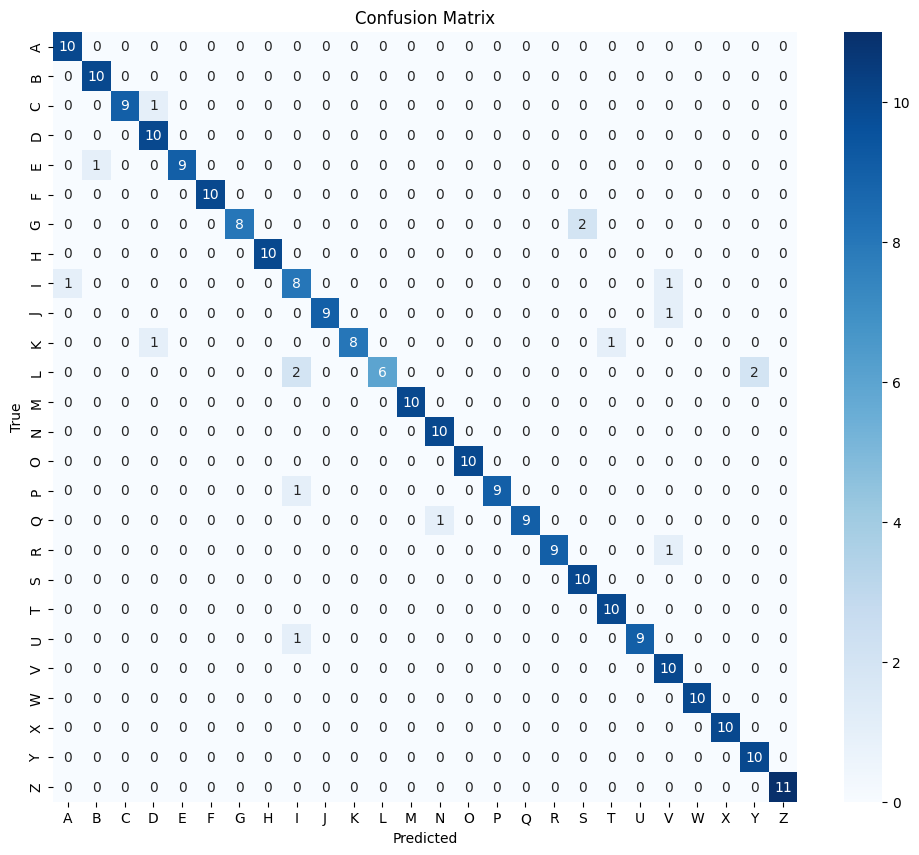

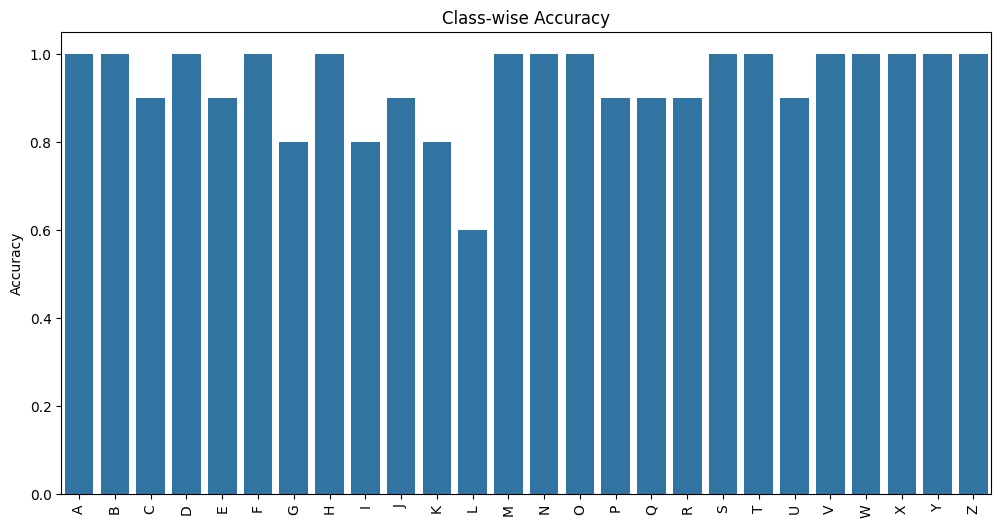

In [ ]:
# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.to(device))
        preds = outputs.argmax(1).cpu()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-score:", f1_score(y_true, y_pred, average='macro'))
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Class-wise Accuracy
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.to(device))
        preds = outputs.argmax(1).cpu()
        for label, pred in zip(labels, preds):
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1
class_acc = class_correct / class_total

plt.figure(figsize=(12,6))
sns.barplot(x=class_names, y=class_acc)
plt.xticks(rotation=90)
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy")
plt.show()

In [ ]:
torch.save(model.state_dict(), "isl_model.pth")

In [ ]:
from PIL import Image

def predict(img: Image.Image):
    model.eval()
    with torch.no_grad():
        x = transform(img).unsqueeze(0).to(device)
        out = model(x)
        return class_names[out.argmax(1).item()]

In [ ]:
import gradio as gr

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="ISL Alphabet Recognition",
    description="Upload a hand sign image (A–Z) to get the predicted letter."
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b16eec9fe43e28fbb7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install mediapipe opencv-python

In [ ]:
!kaggle datasets download -d koushikchouhan/indian-sign-language-animated-videos
!unzip -o /content/indian-sign-language-animated-videos.zip -d /content/ISL_Videos

Dataset URL: https://www.kaggle.com/datasets/koushikchouhan/indian-sign-language-animated-videos
License(s): unknown
indian-sign-language-animated-videos.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/indian-sign-language-animated-videos.zip
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /0.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /1.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /2.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /3.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /4.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /5.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /6.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /7.mp4  
  inflating: /content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDE

In [ ]:
!ls /content/ISL_Videos

'INDIAN SIGN LANGUAGE ANIMATED VIDEOS '


In [ ]:
!ls "/content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS "

 0.mp4		 Cannot.mp4	 Here.mp4       P.mp4		 Walk.mp4
 1.mp4		 Change.mp4	 Her.mp4        Pretty.mp4	 Wash.mp4
 2.mp4		 C.mp4		 His.mp4        Q.mp4		 Way.mp4
 3.mp4		 College.mp4	 H.mp4	        Right.mp4	 Welcome.mp4
 4.mp4		 Come.mp4	 Home.mp4       R.mp4		 We.mp4
 5.mp4		 Computer.mp4	 Homepage.mp4   Sad.mp4		 What.mp4
 6.mp4		 Day.mp4	 How.mp4        Safe.mp4	 When.mp4
 7.mp4		 Distance.mp4	 I.mp4	        See.mp4		 Where.mp4
 8.mp4		 D.mp4		 Invent.mp4     Self.mp4	 Which.mp4
 9.mp4		'Does Not.mp4'	 It.mp4         Sign.mp4	 Whole.mp4
 After.mp4	 Do.mp4		 J.mp4	        Sing.mp4	 Who.mp4
 Again.mp4	'Do Not.mp4'	 Keep.mp4       S.mp4		 Whose.mp4
 Against.mp4	 Eat.mp4	 K.mp4	        So.mp4		 Why.mp4
 Age.mp4	 E.mp4		 Language.mp4   Sound.mp4	 Will.mp4
 All.mp4	 Engineer.mp4	 Laugh.mp4      Stay.mp4	 With.mp4
 Alone.mp4	 Fight.mp4	 Learn.mp4      Study.mp4	 Without.mp4
 Also.mp4	 Finish.mp4	 L.mp4	        Talk.mp4	 W.mp4
 A.mp4		 F.mp4		 ME.mp4         Television.mp4	 Words.mp4
 And.mp4	

In [ ]:
model_video = SignVideoModel(input_dim=42, hidden_dim=128, num_classes=len(class_names))
print("model_video initialized.")

NameError: name 'SignVideoModel' is not defined

In [ ]:
test_path = "/content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /L.mp4"
print(os.path.exists(test_path))   # should be True
print(predict_video(test_path))

In [ ]:
test_path = "/content/ISL_Videos/INDIAN SIGN LANGUAGE ANIMATED VIDEOS /College.mp4"
print(os.path.exists(test_path))   # should be True
print(predict_video(test_path))

In [ ]:
import mediapipe as mp
import cv2
import numpy as np

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)

def extract_landmarks_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    sequence = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        if results.multi_hand_landmarks:
            landmarks = []
            for lm in results.multi_hand_landmarks[0].landmark:
                landmarks.extend([lm.x, lm.y])
            sequence.append(landmarks)
    cap.release()
    return np.array(sequence)

In [ ]:
import torch
import torch.nn as nn

# Define class_names if not already defined
class_names = [chr(i) for i in range(65, 91)]  # A–Z

class SignVideoModel(nn.Module):
    def __init__(self, input_dim=42, hidden_dim=128, num_classes=len(class_names)):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

In [ ]:
def predict_video(video_path, debug=False):
    cap = cv2.VideoCapture(video_path)
    sequence = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0].landmark
            if len(hand_landmarks) == 21:
                # Normalize landmarks relative to wrist
                wrist_x, wrist_y = hand_landmarks[0].x, hand_landmarks[0].y
                landmarks = []
                for lm in hand_landmarks:
                    landmarks.extend([lm.x - wrist_x, lm.y - wrist_y])
                sequence.append(landmarks)
            elif debug:
                print(f"⚠️ Frame {frame_count}: Partial landmark detection")
        elif debug:
            print(f"⚠️ Frame {frame_count}: No hand detected")

    cap.release()

    if debug:
        print(f"✅ Total frames processed: {frame_count}")
        print(f"✅ Frames with valid landmarks: {len(sequence)}")

    # If no valid frames
    if len(sequence) == 0:
        return "No hand detected"

    # Pad or truncate to fixed length
    max_len = 30
    input_dim = len(sequence[0])
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        pad = np.zeros((max_len - len(sequence), input_dim))
        sequence = np.vstack([sequence, pad])

    # Convert to tensor
    x = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, input_dim)

    model_video.eval()
    with torch.no_grad():
        out = model_video(x)
        pred_idx = out.argmax(1).item()
        return class_names[pred_idx]

In [ ]:
demo_video = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),
    outputs="text",
    title="ISL Video Recognition",
    description="Upload a short hand sign video to get the predicted letter.",
    examples=["/content/ISL_Videos/B.mp4"]
)

demo_video.launch()

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload a real hand video

test_path = "/content/uploaded_video.mp4"
print(predict_video(test_path, debug=True))

In [ ]:
demo_video = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),
    outputs="text",
    title="ISL Video Recognition",
    description="Upload a short hand sign video (real hand) to get the predicted letter."
)
demo_video.launch()